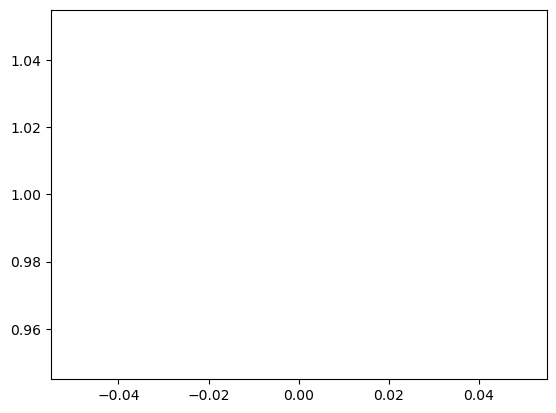

In [30]:
import matplotlib.pyplot as plt
plt.plot([1])

import numpy as np
import gymnasium as gym
from gymnasium import spaces

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax

import logging
import sys
from functools import partial
from pprint import pprint

import gdsfactory as gf
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import sax
from gdsfactory.generic_tech import get_generic_pdk
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from rich.logging import RichHandler
from scipy import constants
from sklearn.linear_model import LinearRegression
from tqdm.notebook import trange

import gplugins.sax as gs
import gplugins.tidy3d as gt
from gplugins.common.config import PATH

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

gf.config.set_plot_options(show_subports=False)

from math import e

In [31]:


class filter_env(gym.Env):

    def __init__(self, render_mode="console"):
        # print("a")
        super(filter_env, self).__init__()

        self.delta_length = -0.5 # normalized
        self.action_space = spaces.Box(
            low=-1, high=1, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(1,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        # print("b")

        super().reset(seed=seed, options=options)

        self.ring_length = -0.5
        return np.array([self.delta_length]).astype(np.float32), {} 

    def loss_function(self, delta_length):

        delta_length_rs=delta_length*0.5+20
        
        def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
            return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})

        def mmi1x2():
            """Assumes a perfect 1x2 splitter"""
            return sax.reciprocal(
                {
                    ("o1", "o2"): 0.5**0.5,
                    ("o1", "o3"): 0.5**0.5,
                }
            )

        def bend_euler(wl=1.5, length=20.0):
            """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
            return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


        models = {
            "bend_euler": bend_euler,
            "mmi1x2": mmi1x2,
            "straight": straight,
        }

        mzi_component = gf.components.mzi(
            delta_length=delta_length_rs,
        )
        
        mzi_circuit, _ = sax.circuit(
            netlist=mzi_component.get_netlist(),
            models=models,
        )

        S = mzi_circuit(
            wl=1.53,
            syl={
                "length": delta_length_rs / 2 + 2,
            },
            straight_9={
                "length": delta_length_rs / 2 + 2,
            },
        )

        return abs(S["o1", "o2"]) ** 2
    

    def step(self, action):
        # print("d")

        if ((action[0] <= 0) & (self.delta_length+action[0]>-1)) | ((action[0] >= 0) & (self.delta_length+action[0]<1)):
            self.delta_length += float(action[0])
            punishment_1 = 0
        else:
            punishment_1 = 1

        punishment_3 = (abs(action[0]))*1

        # reward = 1-self.loss_function_2(self.ring_length, self.coupling)
        reward = (1-self.loss_function(self.delta_length))
        reward = reward-(punishment_1+punishment_3)
     
        reward = float(reward)
        
        terminated = False
        truncated = False  # we do not limit the number of steps here


        info = {}

        return (
            np.array([self.delta_length]).astype(np.float32),
            reward,
            terminated,
            truncated,
            info,
        )


    def close(self):
        # print("e")

        pass


In [32]:
from stable_baselines3.common.env_checker import check_env
env = filter_env()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

from stable_baselines3 import PPO, A2C, DQN, DDPG
from stable_baselines3.common.env_util import make_vec_env

# Instantiate the env
vec_env = make_vec_env(filter_env, n_envs=1)

In [35]:
# Train the agent
model = PPO("MlpPolicy", env, verbose=0, n_steps=10, gamma=0.95).learn(500, progress_bar=True)



Output()

c:\Users\oaper\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 10`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 10
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=10 and n_envs=1)
  warnings.warn(


c:\Users\oaper\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")
c:\Users\oaper\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")
c:\Users\oaper\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")
c:\Users\oaper\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:243: UserWarning: You t

'Final results: delta_length = 0.036981393, reward = [0.91451585]'

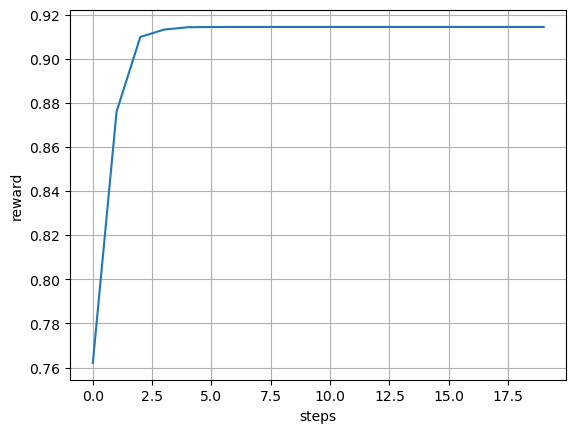

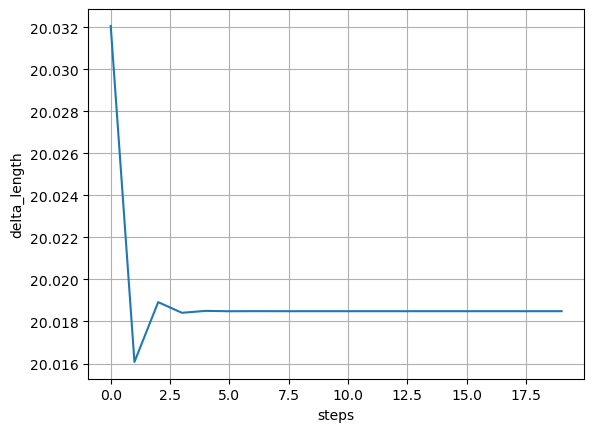

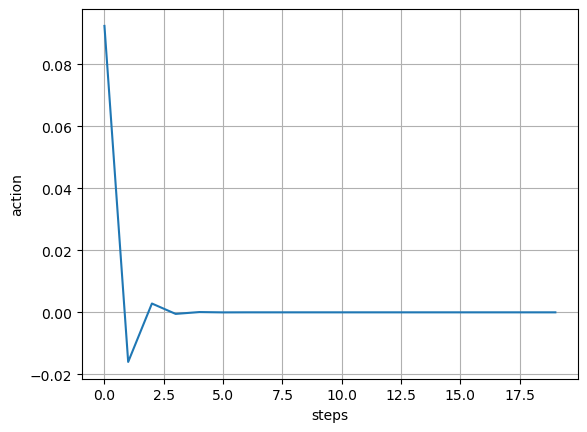

In [36]:
# Test the trained agent
# using the vecenv


obs = vec_env.reset()
obs_array = []
reward_array = []
action_array = []
n_steps = 20
steps_array = np.linspace(1,n_steps,n_steps)
for step in steps_array:
    action, _ = model.predict(obs, deterministic=True)
    #print(f"Step {step + 1}")
    # print("Action: ", action)
    obs, reward, done, info = vec_env.step(action)
    # print("obs=", obs, "reward=", reward, "done=", done)
    vec_env.render()
    obs_array = obs_array + [obs*0.5+20]
    reward_array = reward_array + [reward]
    action_array = action_array + [action*0.5]
    # if reward>1.95:
    #     # Note that the VecEnv resets automatically
    #     # when a done signal is encountered
    #     print("Goal reached!", "reward=", reward)
    #     break

display("Final results: delta_length = " + str(obs[0][0]) + ", reward = "+str(reward) )

plt.figure()
plt.plot(reward_array)
plt.xlabel("steps")
plt.ylabel("reward")
plt.grid()

obs_array_ = np.array(obs_array)
action_array_ = np.array(action_array)

plt.figure()
plt.plot(obs_array_[:,:,0])
plt.xlabel("steps")
plt.ylabel("delta_length")
plt.grid()

plt.figure()
plt.plot(action_array_[:,:,0])
plt.xlabel("steps")
plt.ylabel("action")
plt.grid()
